In [1]:
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import plotly.express as px

from scripts.ds_ultils import *
from scripts.fastf1_data_download import *
from scripts.model_ultils import *
plt.style.use('./scripts/plotstyle.mplstyle')
import warnings
warnings.filterwarnings('ignore')
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, plot_roc_curve,roc_auc_score
from sklearn.feature_selection import SelectKBest, SelectFromModel
from mlxtend.feature_selection import ColumnSelector
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     cross_val_score)
import joblib

In [2]:
qualify_df=pd.read_pickle('./data/model_data/formula1_complete_2018_2022.pkl',compression='gzip')
qualifying_df=qualify_df.copy()
qualifying_df.dropna(inplace=True)
X_test, X_train, y_test, y_train = prepare_modelling_df(qualifying_df)
labelencoder=LabelEncoder()
labelencoder.fit(y_train['lap_timedelta_seconds_binned'])
ydelta_train= labelencoder.transform(y_train['lap_timedelta_seconds_binned'])
ydelta_test= labelencoder.transform(y_test['lap_timedelta_seconds_binned'])
labelencoder=LabelEncoder()
labelencoder.fit(y_train['quali_position_binned'])
ypos_train= labelencoder.transform(y_train['quali_position_binned'])
ypos_test= labelencoder.transform(y_test['quali_position_binned'])

# Manual Feature Selection

In [3]:
feature_importance=pd.read_pickle('./data/model_data/feature_importance_random_forest.pkl')

In [4]:
manual_features = list(feature_importance[feature_importance['Random_forest_result']>0.0105].index)
features_remove =[ 'numerical_transform__avglap_Sector1',
 'numerical_transform__avglap_Sector2',
 'numerical_transform__avglap_Sector3',
 'numerical_transform__max_max_rpm',
 'numerical_transform__mean_var_straight_rpm',
 'numerical_transform__mean_straight_rpm' ]

In [5]:
manual_features = [x for x in manual_features if x not in features_remove]
X_train_manual, X_test_manual = apply_manual_features(X_train,X_test,features=manual_features)
scale_cols, hot_encode_col = column_lists(X_train_manual)

In [6]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

xgboost_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),    
        ('xgboost',XGBClassifier())# classifier
        
]
xg_pipe=Pipeline(xgboost_estimator)

In [7]:
xg_model_pos= xg_pipe.fit(X_train_manual,ypos_train)
print(f'Position XG boost Initial train score with manual selected featuers {xg_model_pos.score(X_train_manual,ypos_train)}')
print(f'Position XG boost Initial test score with manual selected feaure {xg_model_pos.score(X_test_manual,ypos_test)}')
xg_model_delta= xg_pipe.fit(X_train_manual,ydelta_train)
print(f'Lap Delta XG boost Initial train score with manual selected featuers {xg_model_delta.score(X_train_manual,ydelta_train)}')
print(f'Lap Delta XG boost Initial test score with manual selected feaure {xg_model_delta.score(X_test_manual,ydelta_test)}')

Position XG boost Initial train score with manual selected featuers 1.0
Position XG boost Initial test score with manual selected feaure 0.5561224489795918
Lap Delta XG boost Initial train score with manual selected featuers 1.0
Lap Delta XG boost Initial test score with manual selected feaure 0.5612244897959183


## Random Search

In [9]:
param_grid_xg =[
    
    #vary DT parameters only
    {
    'xgboost__n_estimators':np.arange(10,500,10),
    'xgboost__learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    'xgboost__max_depth':np.arange(1,10,2)   
    
    }
   
]

grid_xg = RandomizedSearchCV(xg_pipe, param_grid_xg, cv=5,verbose=1, n_iter=50,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_xg = grid_xg.fit(X_train_manual, ypos_train)

print(fittedgrid_xg.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'xgboost__n_estimators': 40, 'xgboost__max_depth': 3, 'xgboost__learning_rate': 0.3}


In [10]:
print('Best XGboost Position model accuracy_score on X test:',fittedgrid_xg.best_estimator_.score(X_test_manual, ypos_test))

Best XGboost Position model accuracy_score on X test: 0.5408163265306123


In [ ]:
param_grid_xg =[
    
    #vary DT parameters only
    {
    'xgboost__n_estimators':np.arange(20,100,20),
    'xgboost__learning_rate':[ 0.1, 0.15,0.2,0.25,0.3,0.35],
    'xgboost__max_depth':np.arange(1,10,2),

    
    }
   
]

grid_xg = GridSearchCV(xg_pipe, param_grid_xg, cv=5,verbose=1, return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_xg = grid_xg.fit(X_train_manual, ypos_train)

print(fittedgrid_xg.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'xgboost__learning_rate': 0.05, 'xgboost__max_depth': 3, 'xgboost__n_estimators': 280}


In [ ]:
results_xg_pos = pd.DataFrame({'Validation score':fittedgrid_xg.cv_results_['mean_test_score'],
'Train score':fittedgrid_xg.cv_results_['mean_train_score'],
'n_estimators_in_grid':fittedgrid_xg.cv_results_['param_xgboost__n_estimators'],
'learning_rate_in_grid': fittedgrid_xg.cv_results_['param_xgboost__learning_rate'],
'max_depth_in_grid': fittedgrid_xg.cv_results_['param_xgboost__max_depth']
})
results_xg_pos

,Validation score,Train score,n_estimators_in_grid,learning_rate_in_grid,max_depth_in_grid
0,0.510887,0.596676,280,0.05,1
1,0.512651,0.599472,290,0.05,1
2,0.529705,0.706297,280,0.05,2
3,0.530290,0.709535,290,0.05,2
4,0.550897,0.826515,280,0.05,3
5,0.549132,0.829753,290,0.05,3
6,0.533856,0.639790,280,0.1,1
7,0.535036,0.642291,290,0.1,1
8,0.529688,0.803560,280,0.1,2
9,0.526155,0.806797,290,0.1,2


In [ ]:
print('Best XGboost Position model accuracy_score on X test:',fittedgrid_xg.best_estimator_.score(X_test_manual, ypos_test))

Best XGboost Position model accuracy_score on X test: 0.5306122448979592


In [ ]:
# Save the best model
joblib.dump(fittedgrid_xg.best_estimator_, 'pickled_best_XGboost_model_pos.pkl')

['pickled_best_XGboost_model_pos.pkl']

In [ ]:
# get confusion matrix 
y_pred=fittedgrid_xg.best_estimator_.predict(X_test_manual)
RF_confusion_matrix = confusion_matrix(ypos_test,y_pred)

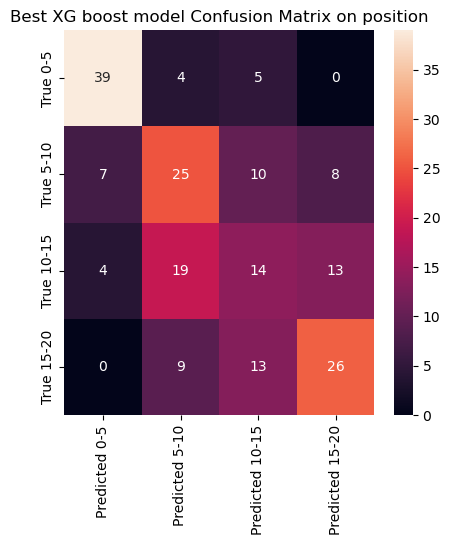

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(RF_confusion_matrix,
    xticklabels=["Predicted 0-5", "Predicted 5-10","Predicted 10-15", "Predicted 15-20" ],
    yticklabels=["True 0-5", "True 5-10","True 10-15", "True 15-20"],
 annot=True, fmt='g')
plt.title('Best XG boost model Confusion Matrix on position')
plt.show()

## XG boost manual selected features on Lap time delta

In [11]:
param_grid_xg =[
    
    #vary DT parameters only
    {
    'xgboost__n_estimators':np.arange(10,500,10),
    'xgboost__learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    'xgboost__max_depth':np.arange(1,10,2)   
    
    }
   
]

grid_xg = RandomizedSearchCV(xg_pipe, param_grid_xg, cv=5,verbose=1, n_iter=50,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_xg = grid_xg.fit(X_train_manual, ydelta_train)

print(fittedgrid_xg.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'xgboost__n_estimators': 140, 'xgboost__max_depth': 1, 'xgboost__learning_rate': 0.1}


In [ ]:
param_grid_xg =[
    
    #vary DT parameters only
    {
    'xgboost__n_estimators':np.arange(250,300,10),
    'xgboost__learning_rate':[0.025,0.05,0.075, 0.1],
    'xgboost__max_depth':np.arange(1,4,1),

    
    }
   
]

grid_xg_lap = GridSearchCV(xg_pipe, param_grid_xg, cv=5,verbose=1, return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_xg_lap = grid_xg_lap.fit(X_train_manual, ydelta_train)

print(fittedgrid_xg_lap.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'xgboost__learning_rate': 0.05, 'xgboost__max_depth': 1, 'xgboost__n_estimators': 250}


In [ ]:
print(fittedgrid_xg_lap.best_params_)

{'xgboost__learning_rate': 0.05, 'xgboost__max_depth': 1, 'xgboost__n_estimators': 250}


In [ ]:
results_xg_pos = pd.DataFrame({'Validation score':fittedgrid_xg_lap.cv_results_['mean_test_score'],
'Train score':fittedgrid_xg_lap.cv_results_['mean_train_score'],
'n_estimators_in_grid':fittedgrid_xg_lap.cv_results_['param_xgboost__n_estimators'],
'learning_rate_in_grid': fittedgrid_xg_lap.cv_results_['param_xgboost__learning_rate'],
'max_depth_in_grid': fittedgrid_xg_lap.cv_results_['param_xgboost__max_depth']
})
results_xg_pos

,Validation score,Train score,n_estimators_in_grid,learning_rate_in_grid,max_depth_in_grid
0,0.534423,0.600058,250,0.025,1
1,0.533837,0.601824,260,0.025,1
2,0.535013,0.604619,270,0.025,1
3,0.534423,0.606974,280,0.025,1
4,0.533247,0.607857,290,0.025,1
5,0.525004,0.684815,250,0.025,2
6,0.524416,0.687905,260,0.025,2
7,0.522653,0.691437,270,0.025,2
8,0.524418,0.695998,280,0.025,2
9,0.524418,0.698646,290,0.025,2


In [ ]:
print('Best XGboost lap time delta model accuracy_score on X test:',fittedgrid_xg_lap.best_estimator_.score(X_test_manual, ydelta_test))

Best XGboost lap time delta model accuracy_score on X test: 0.5816326530612245


In [ ]:
# Save the best model
joblib.dump(fittedgrid_xg_lap.best_estimator_, 'pickled_best_XGboost_model_lap_delta.pkl')

['pickled_best_XGboost_model_lap_delta.pkl']

In [ ]:
# get confusion matrix 
y_pred=fittedgrid_xg_lap.best_estimator_.predict(X_test_manual)
RF_confusion_matrix = confusion_matrix(ydelta_test,y_pred)

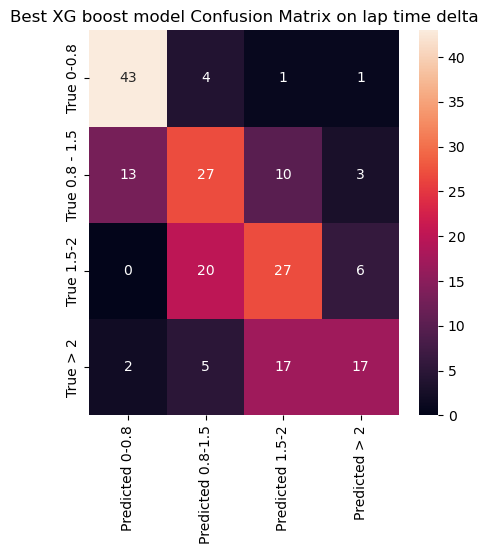

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(RF_confusion_matrix,
    xticklabels=["Predicted 0-0.8", "Predicted 0.8-1.5","Predicted 1.5-2", "Predicted > 2" ],
    yticklabels=["True 0-0.8", "True 0.8 - 1.5","True 1.5-2", "True > 2"],
 annot=True, fmt='g')
plt.title('Best XG boost model Confusion Matrix on lap time delta')
plt.show()